# A simple VWAP Profile

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
from sklearn import linear_model as linear_model

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 2))



ImportError: No module named 'sklearn.__check_build._check_build'
___________________________________________________________________________
Contents of e:\ProgramData\Anaconda3\lib\site-packages\sklearn\__check_build:
setup.py                  _check_build.cp37-win_amd64.pyd__init__.py
__pycache__
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it: run `python setup.py install` or
`make` in the source directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.

In [2]:
# load TWTR trades for the month
# tick data sourced from Wharton WRDS
twtr_trades = pd.read_csv('SQ_trades_201902.zip')

In [17]:
twtr_trades.head()

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_CORR,TR_SEQNUM,TR_SOURCE,TR_RF
0,20190201,4:19:07.749578000,P,SQ,NaN,TI,48,71.40,0,98601,C,NaN
1,20190201,4:19:46.207264000,P,SQ,NaN,TI,42,71.40,0,98701,C,NaN
2,20190201,4:19:46.207314000,P,SQ,NaN,TI,8,71.55,0,98801,C,NaN
3,20190201,5:18:55.674830000,T,SQ,NaN,FTI,1,71.35,0,140301,C,NaN
4,20190201,5:18:55.674872000,T,SQ,NaN,FT,100,71.95,0,140401,C,NaN


In [19]:
twtr_trades['DATE'] = twtr_trades['DATE'].astype('str')

In [20]:
twtr_trades.dtypes

DATE           object
TIME_M         object
EX             object
SYM_ROOT       object
SYM_SUFFIX    float64
TR_SCOND       object
SIZE            int64
PRICE         float64
TR_CORR         int64
TR_SEQNUM       int64
TR_SOURCE      object
TR_RF          object
dtype: object

In [28]:
twtr_trades['DateTime'] = twtr_trades['DATE'] + ' ' + twtr_trades['TIME_M']
twtr_trades['DateTime'] = pd.DatetimeIndex(twtr_trades['DateTime'])
twtr_trades.set_index(keys = 'DateTime', inplace = True)

In [29]:
twtr_trades.head()

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_CORR,TR_SEQNUM,TR_SOURCE,TR_RF
DateTime,,,,,,,,,,,,
2019-02-01 04:19:07.749578,20190201,4:19:07.749578000,P,SQ,NaN,TI,48,71.40,0,98601,C,NaN
2019-02-01 04:19:46.207264,20190201,4:19:46.207264000,P,SQ,NaN,TI,42,71.40,0,98701,C,NaN
2019-02-01 04:19:46.207314,20190201,4:19:46.207314000,P,SQ,NaN,TI,8,71.55,0,98801,C,NaN
2019-02-01 05:18:55.674830,20190201,5:18:55.674830000,T,SQ,NaN,FTI,1,71.35,0,140301,C,NaN
2019-02-01 05:18:55.674872,20190201,5:18:55.674872000,T,SQ,NaN,FT,100,71.95,0,140401,C,NaN


In [30]:
type(twtr_trades.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [31]:
# let's clean up the before and after hours times
twtr_trades = twtr_trades.between_time( '09:30:00', '16:00:00' )

In [32]:
twtr_trades['2019-02-15'].tail()

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_CORR,TR_SEQNUM,TR_SOURCE,TR_RF
DateTime,,,,,,,,,,,,
2019-02-15 15:59:59.944258,20190215,15:59:59.944258000,N,SQ,NaN,F,223,75.65,0,204102101,C,NaN
2019-02-15 15:59:59.944349,20190215,15:59:59.944349000,K,SQ,NaN,F,200,75.65,0,204102201,C,NaN
2019-02-15 15:59:59.944416,20190215,15:59:59.944416000,K,SQ,NaN,F,100,75.65,0,204102401,C,NaN
2019-02-15 15:59:59.945079,20190215,15:59:59.945079000,N,SQ,NaN,F,100,75.65,0,204103201,C,NaN
2019-02-15 15:59:59.970561,20190215,15:59:59.970561000,J,SQ,NaN,NaN,100,75.64,0,204116801,C,NaN


In [5]:
# now let's make some 1 minute data using resample
minute_data = pd.DataFrame()
minute_data['open'] = twtr_trades['trade_price'].resample('Min').first()
minute_data['close'] = twtr_trades['trade_price'].resample('Min').last()
minute_data['high'] = twtr_trades['trade_price'].resample('Min').max()
minute_data['low'] = twtr_trades['trade_price'].resample('Min').min()
minute_data['volume'] = twtr_trades['trade_qty'].resample('Min').sum()

In [6]:
minute_data['2019-01-15'].head()

,open,close,high,low,volume
2019-01-15 00:00:00,NaN,NaN,NaN,NaN,0
2019-01-15 00:01:00,NaN,NaN,NaN,NaN,0
2019-01-15 00:02:00,NaN,NaN,NaN,NaN,0
2019-01-15 00:03:00,NaN,NaN,NaN,NaN,0
2019-01-15 00:04:00,NaN,NaN,NaN,NaN,0


In [7]:
# resample adds every interval in the data set, so let's clean this up too
minute_data = minute_data.between_time('09:30:00', '16:00:00')

# let's also get rid of weekend days
minute_data = minute_data[minute_data.index.dayofweek < 5]

In [8]:
minute_data.tail()

,open,close,high,low,volume
2019-01-31 15:55:00,33.5300,33.557,33.565,33.5111,156428
2019-01-31 15:56:00,33.5500,33.560,33.570,33.5400,62155
2019-01-31 15:57:00,33.5600,33.540,33.570,33.5200,172071
2019-01-31 15:58:00,33.5399,33.540,33.550,33.5200,157539
2019-01-31 15:59:00,33.5500,33.540,33.570,33.5300,309192


In [10]:
# calculate the cumulative pct by day
minute_data[ 'accum_volume' ] = minute_data.groupby( [ minute_data.index.date ] ).cumsum()[ 'volume' ] 
minute_data[ 'accum_pct' ] = minute_data.groupby( [ minute_data.index.date ] )[ 'accum_volume' ].transform( lambda x: x / x.iloc[ -1 ] )

In [11]:
minute_data['2019-01-25'].tail()

,open,close,high,low,volume,accum_volume,accum_pct
2019-01-25 15:56:00,32.891,32.895,32.9000,32.88,68165,21073563,0.975049
2019-01-25 15:57:00,32.890,32.885,32.9059,32.87,107208,21180771,0.980010
2019-01-25 15:58:00,32.885,32.870,32.9000,32.87,147805,21328576,0.986848
2019-01-25 15:59:00,32.870,32.900,32.9200,32.87,284246,21612822,1.000000
2019-01-25 16:00:00,NaN,NaN,NaN,NaN,0,21612822,1.000000


In [12]:
# add a minute bin
# US start of date, calc in minutes
start_of_day = ( 9 * 60 ) + 30
# get the time for each bin in minutes and subtract 9:30
minute_data[ 'minute_bars' ] = ( minute_data.index.hour * 60 ) + minute_data.index.minute - start_of_day

In [13]:
minute_data['2019-01-03'].head()

,open,close,high,low,volume,accum_volume,accum_pct,minute_bars
2019-01-03 09:30:00,28.4100,28.5900,28.67,28.33,191347,191347,0.010615,0
2019-01-03 09:31:00,28.6100,28.6500,28.66,28.57,71068,262415,0.014557,1
2019-01-03 09:32:00,28.6647,28.7500,28.77,28.61,80872,343287,0.019043,2
2019-01-03 09:33:00,28.7500,28.7799,28.81,28.70,76216,419503,0.023271,3
2019-01-03 09:34:00,28.7700,28.7201,28.81,28.60,123011,542514,0.030095,4


In [14]:
minute_data['accum_pct']['2019-01-25']

2019-01-25 09:30:00    0.017094
2019-01-25 09:31:00    0.021618
2019-01-25 09:32:00    0.024903
2019-01-25 09:33:00    0.033447
2019-01-25 09:34:00    0.039234
2019-01-25 09:35:00    0.050115
2019-01-25 09:36:00    0.060842
2019-01-25 09:37:00    0.073259
2019-01-25 09:38:00    0.079717
2019-01-25 09:39:00    0.089273
2019-01-25 09:40:00    0.094078
2019-01-25 09:41:00    0.096541
2019-01-25 09:42:00    0.099901
2019-01-25 09:43:00    0.102940
2019-01-25 09:44:00    0.109074
2019-01-25 09:45:00    0.112992
2019-01-25 09:46:00    0.116311
2019-01-25 09:47:00    0.118064
2019-01-25 09:48:00    0.120944
2019-01-25 09:49:00    0.125881
2019-01-25 09:50:00    0.131581
2019-01-25 09:51:00    0.135141
2019-01-25 09:52:00    0.136767
2019-01-25 09:53:00    0.139755
2019-01-25 09:54:00    0.144543
2019-01-25 09:55:00    0.149253
2019-01-25 09:56:00    0.160565
2019-01-25 09:57:00    0.164804
2019-01-25 09:58:00    0.169567
2019-01-25 09:59:00    0.173815
                         ...   
2019-01-

In [15]:
# arrange our data
minute_bars = minute_data[ 'minute_bars' ]
X = pd.DataFrame( { 'bin': minute_bars, 
                    'bin2' : minute_bars**2, 
                    'bin3' : minute_bars**3, 
                    'bin4' : minute_bars**4, 
                    'bin5' : minute_bars**5 } )
y = minute_data[ 'accum_pct' ]

In [16]:
# now do the regression
lm = linear_model.LinearRegression()
model = lm.fit( X, y )
predictions = lm.predict( X )
# Rsquared
lm.score( X, y )

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [17]:
# do we have any null values?
y[y.isnull()]

2019-01-21 09:30:00   NaN
2019-01-21 09:31:00   NaN
2019-01-21 09:32:00   NaN
2019-01-21 09:33:00   NaN
2019-01-21 09:34:00   NaN
2019-01-21 09:35:00   NaN
2019-01-21 09:36:00   NaN
2019-01-21 09:37:00   NaN
2019-01-21 09:38:00   NaN
2019-01-21 09:39:00   NaN
2019-01-21 09:40:00   NaN
2019-01-21 09:41:00   NaN
2019-01-21 09:42:00   NaN
2019-01-21 09:43:00   NaN
2019-01-21 09:44:00   NaN
2019-01-21 09:45:00   NaN
2019-01-21 09:46:00   NaN
2019-01-21 09:47:00   NaN
2019-01-21 09:48:00   NaN
2019-01-21 09:49:00   NaN
2019-01-21 09:50:00   NaN
2019-01-21 09:51:00   NaN
2019-01-21 09:52:00   NaN
2019-01-21 09:53:00   NaN
2019-01-21 09:54:00   NaN
2019-01-21 09:55:00   NaN
2019-01-21 09:56:00   NaN
2019-01-21 09:57:00   NaN
2019-01-21 09:58:00   NaN
2019-01-21 09:59:00   NaN
                       ..
2019-01-21 15:31:00   NaN
2019-01-21 15:32:00   NaN
2019-01-21 15:33:00   NaN
2019-01-21 15:34:00   NaN
2019-01-21 15:35:00   NaN
2019-01-21 15:36:00   NaN
2019-01-21 15:37:00   NaN
2019-01-21 1

In [18]:
yfixed = y.loc[ ( y.index < '2019-01-21 00:00:00' ) | ( y.index > '2019-01-21 23:59:59' ) ]
Xfixed = X.loc[ ( X.index < '2019-01-21 00:00:00' ) | ( X.index > '2019-01-21 23:59:59' ) ]

In [19]:
len(Xfixed)

8210

In [20]:
len(yfixed)

8210

In [21]:
Xfixed.index.difference(yfixed.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [22]:
# try this again
lm = linear_model.LinearRegression()
model = lm.fit( Xfixed, yfixed )
predictions = lm.predict( Xfixed )
# Rsquared
lm.score( Xfixed, yfixed )

0.9691704428045708

In [23]:
# coefficients
lm.coef_

array([ 6.40950159e-03, -3.56285116e-05,  1.40641966e-07, -3.00185328e-10,
        2.73625684e-13])

In [24]:
lm.intercept_

0.024317712987938944

In [25]:
# now do the regression with no intercept
lm2 = linear_model.LinearRegression( fit_intercept = False )
model = lm2.fit( Xfixed, yfixed )
predictions = lm2.predict( Xfixed )

# Rsquared
lm2.score( Xfixed, yfixed )

0.9688671641874764

In [26]:
lm2.coef_

array([ 7.49930092e-03, -5.05137528e-05,  2.26416619e-07, -5.19862243e-10,
        4.79918459e-13])

In [27]:
lm2.intercept_

0.0

In [28]:
def vwap_target( bar_num, coefs ):
    return ( coefs[ 0 ] * bar_num + 
             coefs[ 1 ] * bar_num**2 + 
             coefs[ 2 ] * bar_num**3 +
             coefs[ 3 ] * bar_num**4 +
             coefs[ 4 ] * bar_num**5 )

In [29]:
bins = np.arange(0,391)
tgts = vwap_target( bins, lm2.coef_ )

In [30]:
tgts

array([0.        , 0.00744901, 0.01479835, 0.02204935, 0.02920334,
       0.03626164, 0.04322555, 0.05009635, 0.05687534, 0.06356377,
       0.0701629 , 0.07667397, 0.08309822, 0.08943686, 0.09569109,
       0.10186212, 0.10795113, 0.11395929, 0.11988776, 0.12573768,
       0.13151021, 0.13720646, 0.14282754, 0.14837457, 0.15384863,
       0.1592508 , 0.16458216, 0.16984377, 0.17503666, 0.18016189,
       0.18522047, 0.19021343, 0.19514175, 0.20000645, 0.20480851,
       0.20954889, 0.21422855, 0.21884846, 0.22340955, 0.22791275,
       0.23235899, 0.23674917, 0.2410842 , 0.24536496, 0.24959234,
       0.2537672 , 0.25789041, 0.26196282, 0.26598526, 0.26995858,
       0.27388358, 0.27776108, 0.28159188, 0.28537678, 0.28911656,
       0.29281198, 0.29646383, 0.30007284, 0.30363977, 0.30716535,
       0.3106503 , 0.31409536, 0.31750122, 0.32086859, 0.32419815,
       0.3274906 , 0.33074659, 0.33396681, 0.3371519 , 0.34030251,
       0.34341928, 0.34650285, 0.34955382, 0.35257282, 0.35556

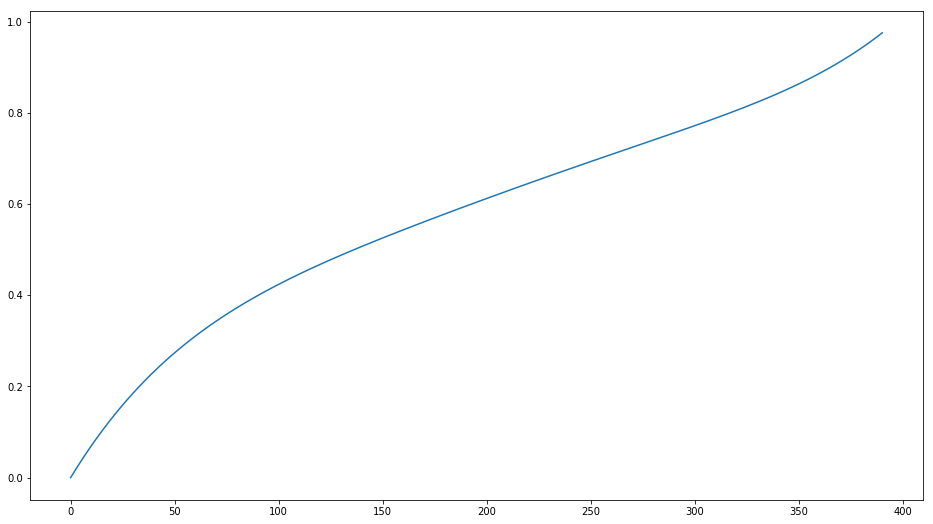

In [31]:
fig, ax1 = plt.subplots(figsize=(16,9))
plt.plot(tgts)

In [32]:
tgts[-1]

0.975712572912153

In [33]:
# or is there something about this that keeps it from getting to 1.0 that I'm forgetting?
minute_data.index

DatetimeIndex(['2019-01-02 09:30:00', '2019-01-02 09:31:00',
               '2019-01-02 09:32:00', '2019-01-02 09:33:00',
               '2019-01-02 09:34:00', '2019-01-02 09:35:00',
               '2019-01-02 09:36:00', '2019-01-02 09:37:00',
               '2019-01-02 09:38:00', '2019-01-02 09:39:00',
               ...
               '2019-01-31 15:50:00', '2019-01-31 15:51:00',
               '2019-01-31 15:52:00', '2019-01-31 15:53:00',
               '2019-01-31 15:54:00', '2019-01-31 15:55:00',
               '2019-01-31 15:56:00', '2019-01-31 15:57:00',
               '2019-01-31 15:58:00', '2019-01-31 15:59:00'],
              dtype='datetime64[ns]', length=8601, freq=None)

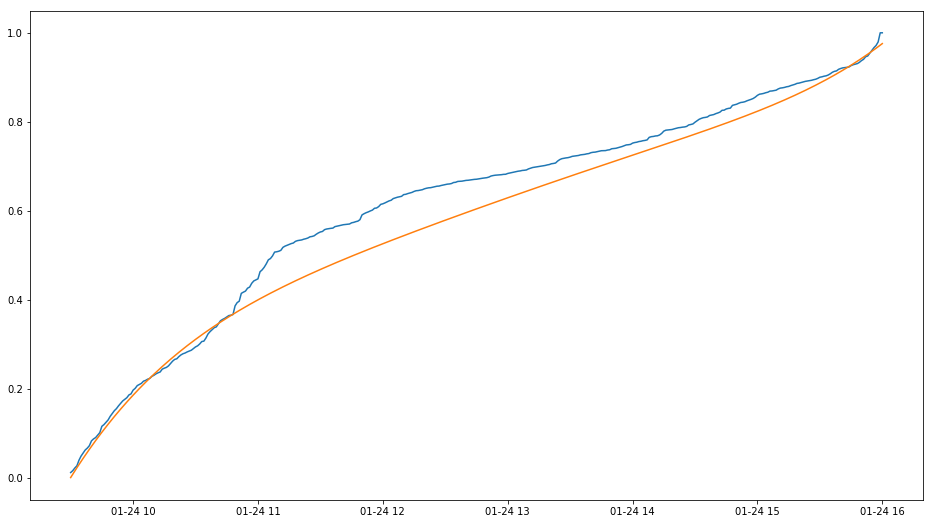

In [36]:
tgt_date = '1-24-2019'
fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )
ax1.plot( minute_data[ tgt_date ] [ 'accum_pct' ] )
tgtsSeries = pd.Series( tgts )
tgtsSeries.index = minute_data[ tgt_date ].index
ax1.plot( tgtsSeries )
plt.show()

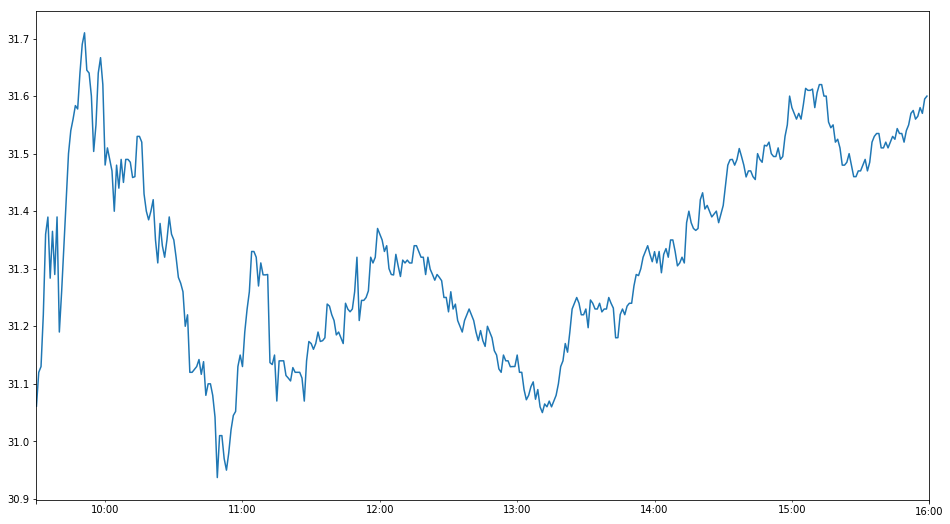

In [37]:
minute_data[ tgt_date ]['close'].plot(figsize=(16,9))

## Now by binwise averages

In [38]:
# now calculate binwise averages
target_pct_mean = minute_data.groupby( 'minute_bars' ).mean()[ 'accum_pct' ]

## How do they look?

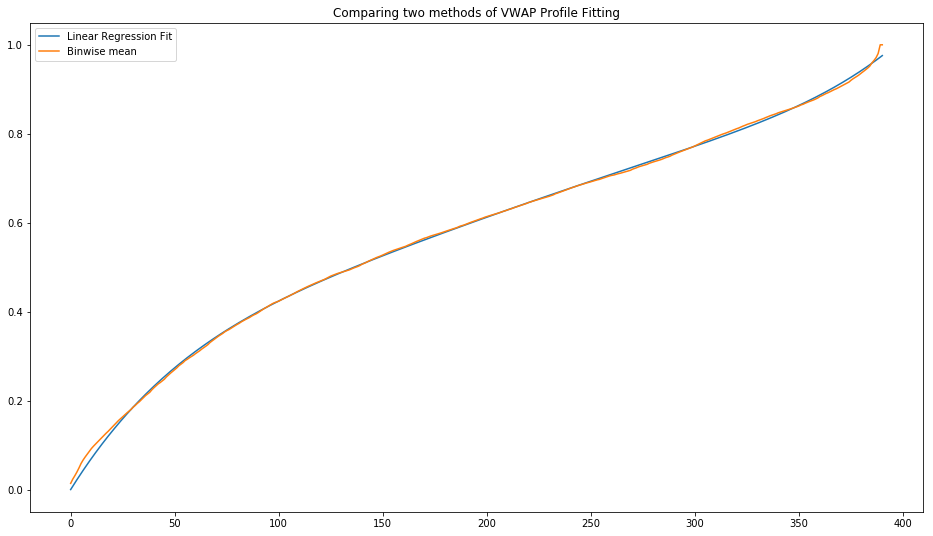

In [39]:
fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )
plt.plot( tgts, label = 'Linear Regression Fit' )
plt.plot( target_pct_mean, label = 'Binwise mean' )
plt.title( 'Comparing two methods of VWAP Profile Fitting' )
plt.legend()

## Let's compare with a single day

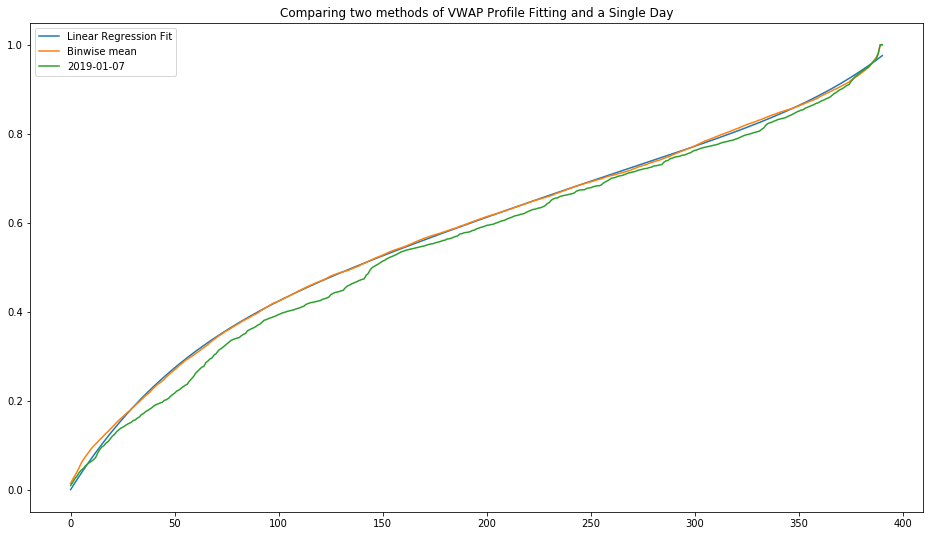

In [40]:
plt.subplots( figsize = ( 16, 9 ) )
study_date = '2019-01-07'
one_day = minute_data[ study_date ][ 'accum_pct' ].reset_index( drop = True )

plt.plot( tgts, label = 'Linear Regression Fit' )
plt.plot( target_pct_mean, label = 'Binwise mean' )
plt.plot( one_day, label = study_date )

plt.title( 'Comparing two methods of VWAP Profile Fitting and a Single Day' )
plt.legend()

## Maybe a different day?

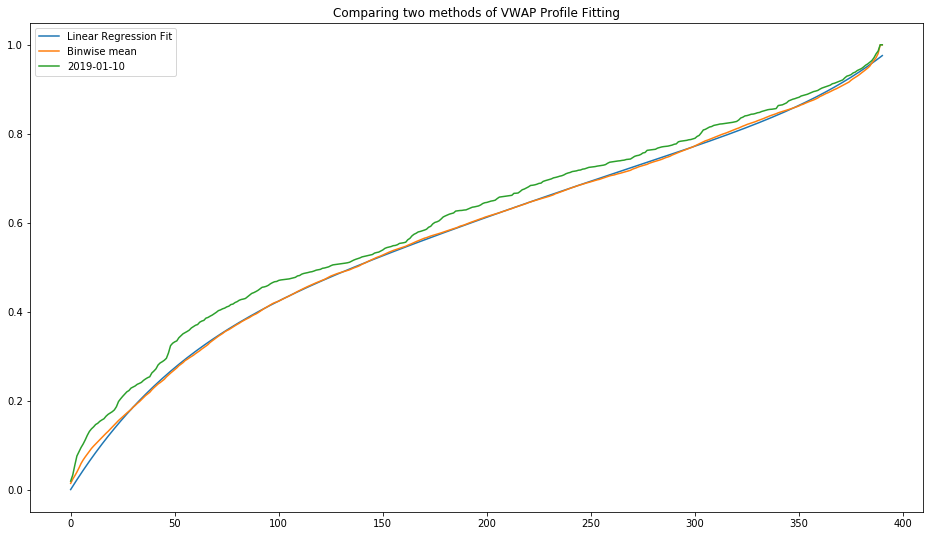

In [41]:
plt.subplots(figsize=(16,9))
study_date = '2019-01-10'

another_day = minute_data[ study_date ][ 'accum_pct' ].reset_index( drop = True)

plt.plot( tgts, label = 'Linear Regression Fit' )
plt.plot( target_pct_mean, label = 'Binwise mean' )
plt.plot( another_day, label = study_date )

plt.title( 'Comparing two methods of VWAP Profile Fitting' )
plt.legend()

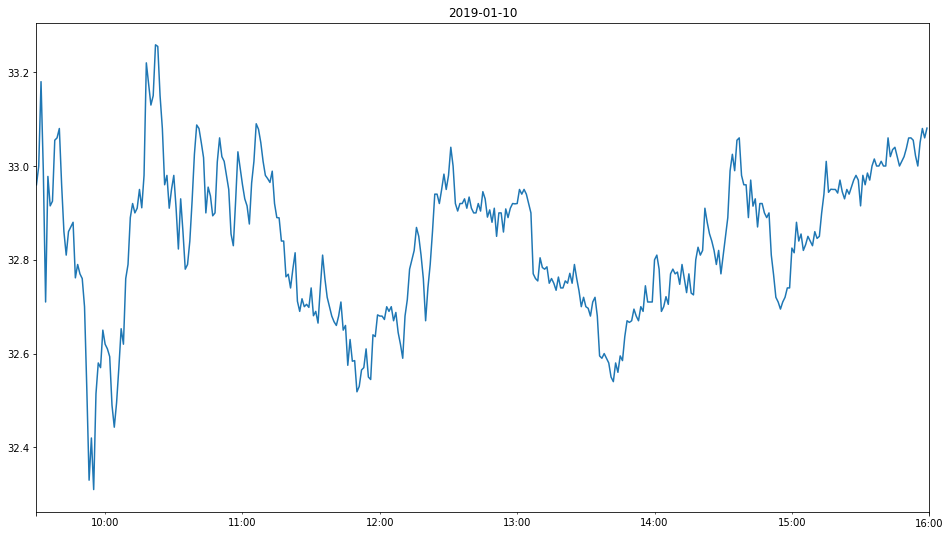

In [42]:
minute_data[ study_date ][ 'close' ].plot( figsize = ( 16, 9 ), title=study_date )